In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
import os
%matplotlib inline

# Source Model

Here I explore potential methods for populating the sample of source galaxies which will be used in the lens model. The chosen method must:
- realistically represent the morphologies of galaxies at the chosen redshift range. 
- have a high enough resolution such that magnification from the lens doesn't cause the source to be pixelated.

I will explore the following methods:
- JWST images of high redshift galaxies
- Simulated galaxies from IllustrisTNG
- Local blue compact dwarf galaxies

## JWST images of high redshift galaxies

In my previous work I had chosen to position the source plane between z=1-2 because it produces a large enought eintein radius to significantly sample inner substructure population. Whether that is actually true will be explored in a later notebook. For now I want to visualise the kinds of galaxies that are present at this redshift range.

In [115]:
# Define the directory containing the files
directory = '/fred/oz149/tyler_gals/'

# Import the metadata
catalog = pd.read_csv(f'{directory}catalog.csv', index_col='ID')

# Filter the catalog to only include objects with 1 < z < 2
z_phot = catalog['photoz']
z_filtered = z_phot[(z_phot > 1) & (z_phot < 2)]
idx = z_filtered.index

print(len(idx))

5194


We dont have images for each idex in the dataframe so I will have to create a list of the ones that I do have and cross reference that with the dataframe.

In [117]:
# Get a list of all files in the directory
files = os.listdir(directory)

# Extract the text between the _ and . characters in each filename
names = [f.split('_')[0] for f in files]

# Get a set of unique names
target_names = np.array(list(set(names)))
print(target_names)

# Remove the name catalog.csv from the list
target_names = target_names[target_names != 'catalog.csv'].astype(int)

# Cross reference the target names with the filtered catalog
target_names = np.intersect1d(target_names, idx.values)

print(f'There are {len(target_names)} targets in the catalog with 1 < z < 2')

['3223' '1763' '6075' ... '1268' '169' '3743']
There are 1389 targets in the catalog with 1 < z < 2


In [118]:
# For each target there are several filters, I need to load in images from each filter

# Filters
filters = np.array(['f090w', 'f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w'])

file_names = []
for target in target_names:
    for filt in filters:
        file_names.append(f"{target}_{filt}.fits")

print(f'There are {len(file_names)} files to load')

# Load in the images
images = np.zeros((len(target_names), len(filters), 100, 100))

for i in range(len(target_names)):
    for j in range(len(filters)):
        image = fits.open(f'{directory}{target_names[i]}_{filters[j]}.fits')[0].data
        images[i, j] = image


There are 9723 files to load


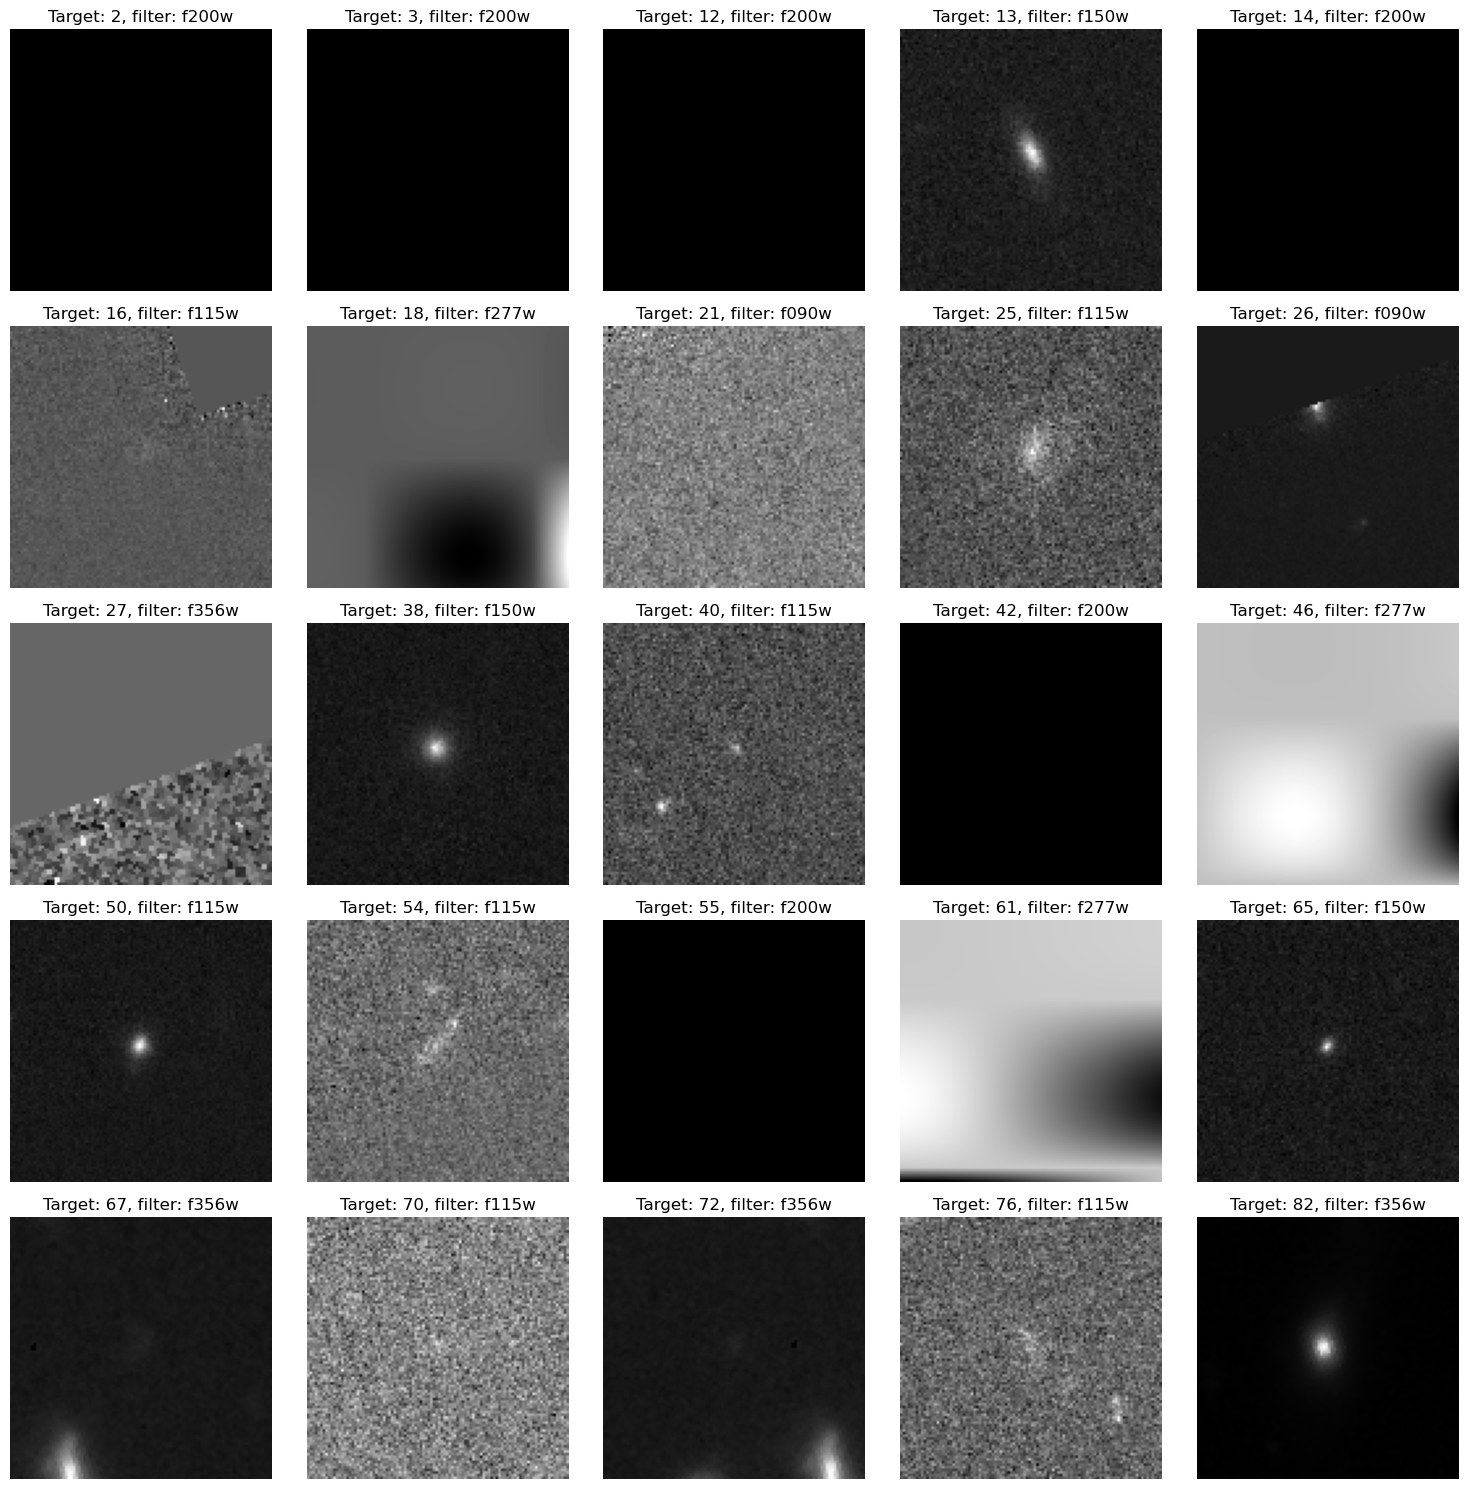

In [119]:
# Plot a sample of images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(5*5):
    filter = np.random.randint(0,6)
    axes[i].imshow(images[i, filter], cmap='gray')
    axes[i].set_title(f'Target: {target_names[i]}, filter: {filters[filter]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Log(Lookback Time) [yr]')

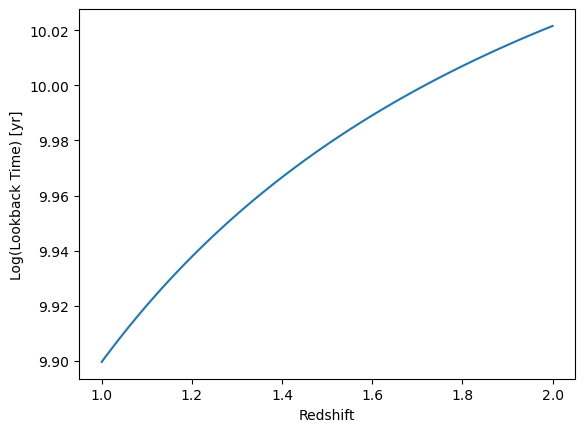

In [120]:
from astropy.cosmology import Planck18
import astropy.units as u

# Define the redshift and cosmology
redshift = np.linspace(1, 2, 100)
cosmo = Planck18

# Calculate the lookback time in years
lookback_time = cosmo.lookback_time(redshift).to('yr')

# Plot the lookback time as a function of redshift
plt.plot(redshift, np.log10(lookback_time.value))
plt.xlabel('Redshift')
plt.ylabel('Log(Lookback Time) [yr]')

### Filter by f/e

[   1    1    1 ... 1388 1388 1388] [1 2 3 ... 4 5 6]


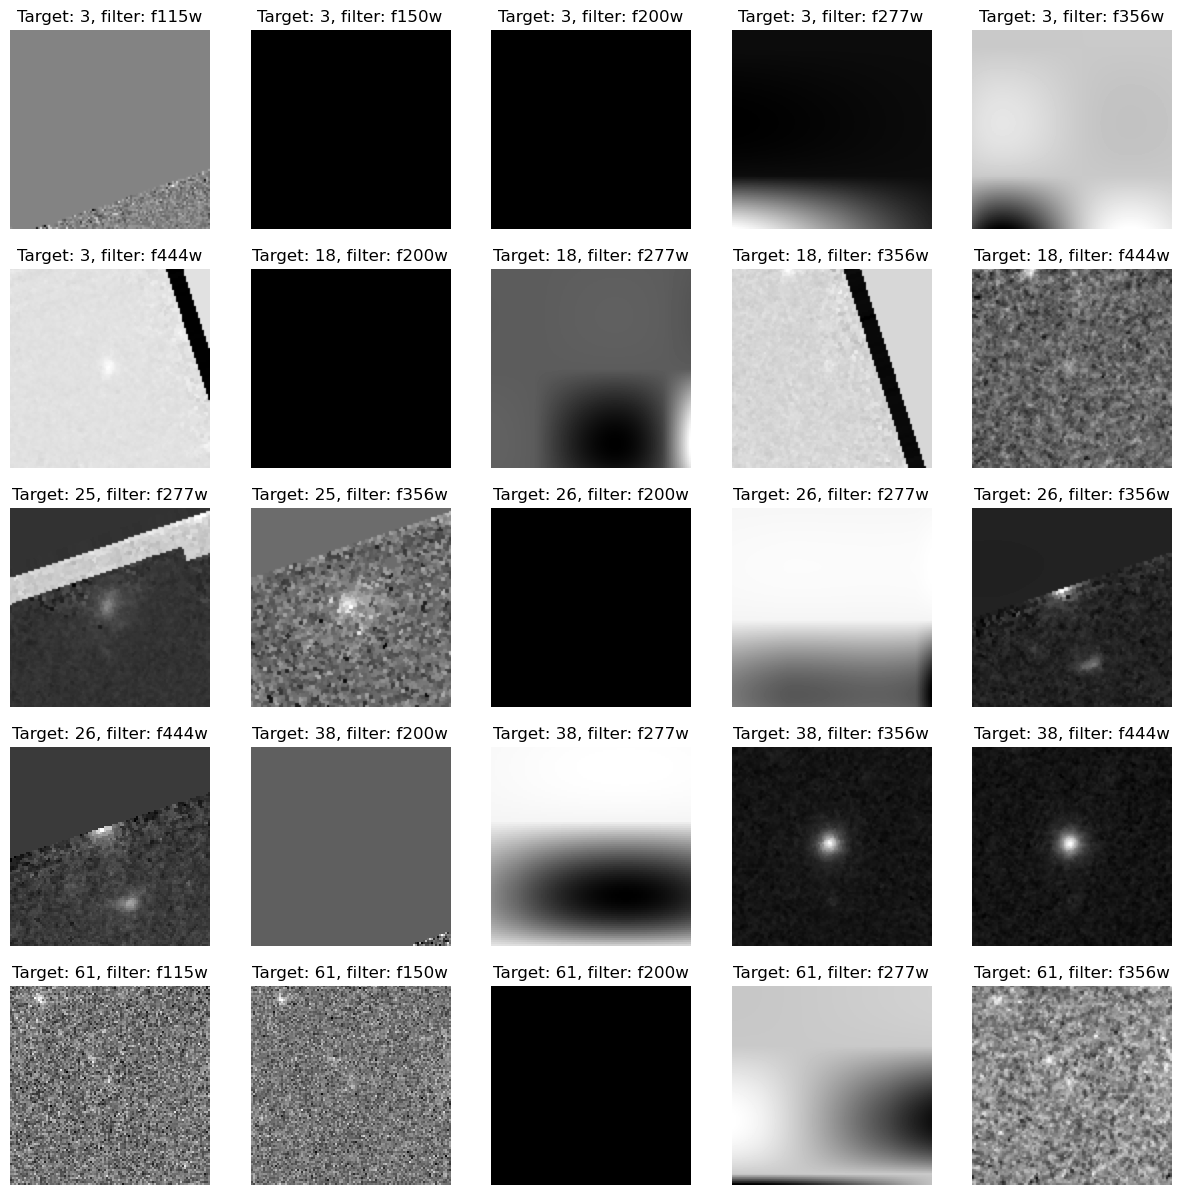

In [152]:
signal = catalog[['f_f090w', 'f_f115w', 'f_f150w', 'f_f200w', 'f_f277w', 'f_f356w', 'f_f444w']].loc[target_names]
errors = catalog[['e_f090w', 'e_f115w', 'e_f150w', 'e_f200w', 'e_f277w', 'e_f356w', 'e_f444w']].loc[target_names]

snr = signal.values / errors.values 

threshold = 100

# get the location of the signal values that are greater than the threshold

low_noise_target, low_noise_filter = np.where(snr > threshold)
print(low_noise_target, low_noise_filter)

# get the images that have signal greater than the threshold

low_noise_images = images[low_noise_target, low_noise_filter]

#plot a sample of the images

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(5*5):
    axes[i].imshow(low_noise_images[i], cmap='gray')
    axes[i].set_title(f'Target: {target_names[low_noise_target[i]]}, filter: {filters[low_noise_filter[i]]}')
    axes[i].axis('off')


#### Filter by max/stdev

The PSNR is 18.24


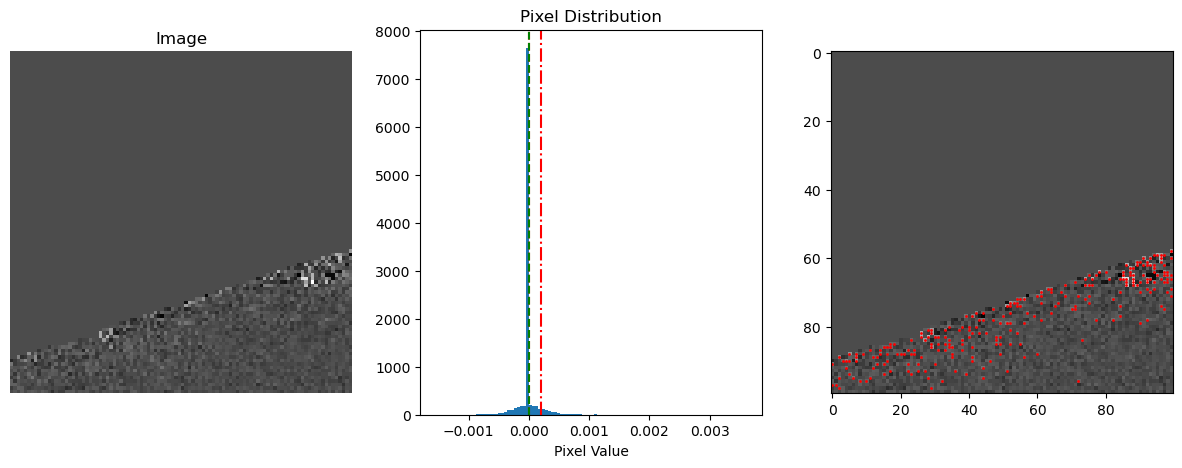

In [153]:
image_test = images[30, 3]

pixel_dist = image_test.flatten()
pixel_dist_mean = np.mean(pixel_dist)
pixel_dist_median = np.median(pixel_dist)
pixel_dist_std = np.std(pixel_dist)
pixel_dist_peak = np.max(pixel_dist)

psnr = pixel_dist_peak/pixel_dist_std
print(f'The PSNR is {psnr:.2f}')

# Get all pixels positions greater than 1 standard deviation from the mean

pixel_outliers = np.where((image_test > pixel_dist_mean + 2*pixel_dist_std))


# Plot the image

fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(image_test, cmap='gray')
ax[0].set_title('Image')
ax[0].axis('off')

# Plot the pixel distribution

ax[1].hist(pixel_dist, bins=100)
ax[1].axvline(pixel_dist_mean, color='r', linestyle='--', label='Mean')
ax[1].axvline(pixel_dist_median, color='g', linestyle='--', label='Median')
ax[1].axvline(pixel_dist_mean + pixel_dist_std, color='r', linestyle='-.', label='1 Std')
ax[1].set_title('Pixel Distribution')
ax[1].set_xlabel('Pixel Value')

# Plot the outliers

ax[2].imshow(image_test, cmap='gray')
ax[2].scatter(pixel_outliers[1], pixel_outliers[0], color='r', s=1)

/tmp/ipykernel_3235870/1670472911.py:4: RuntimeWarning: invalid value encountered in true_divide
  psnr = pixel_peaks/pixel_stds


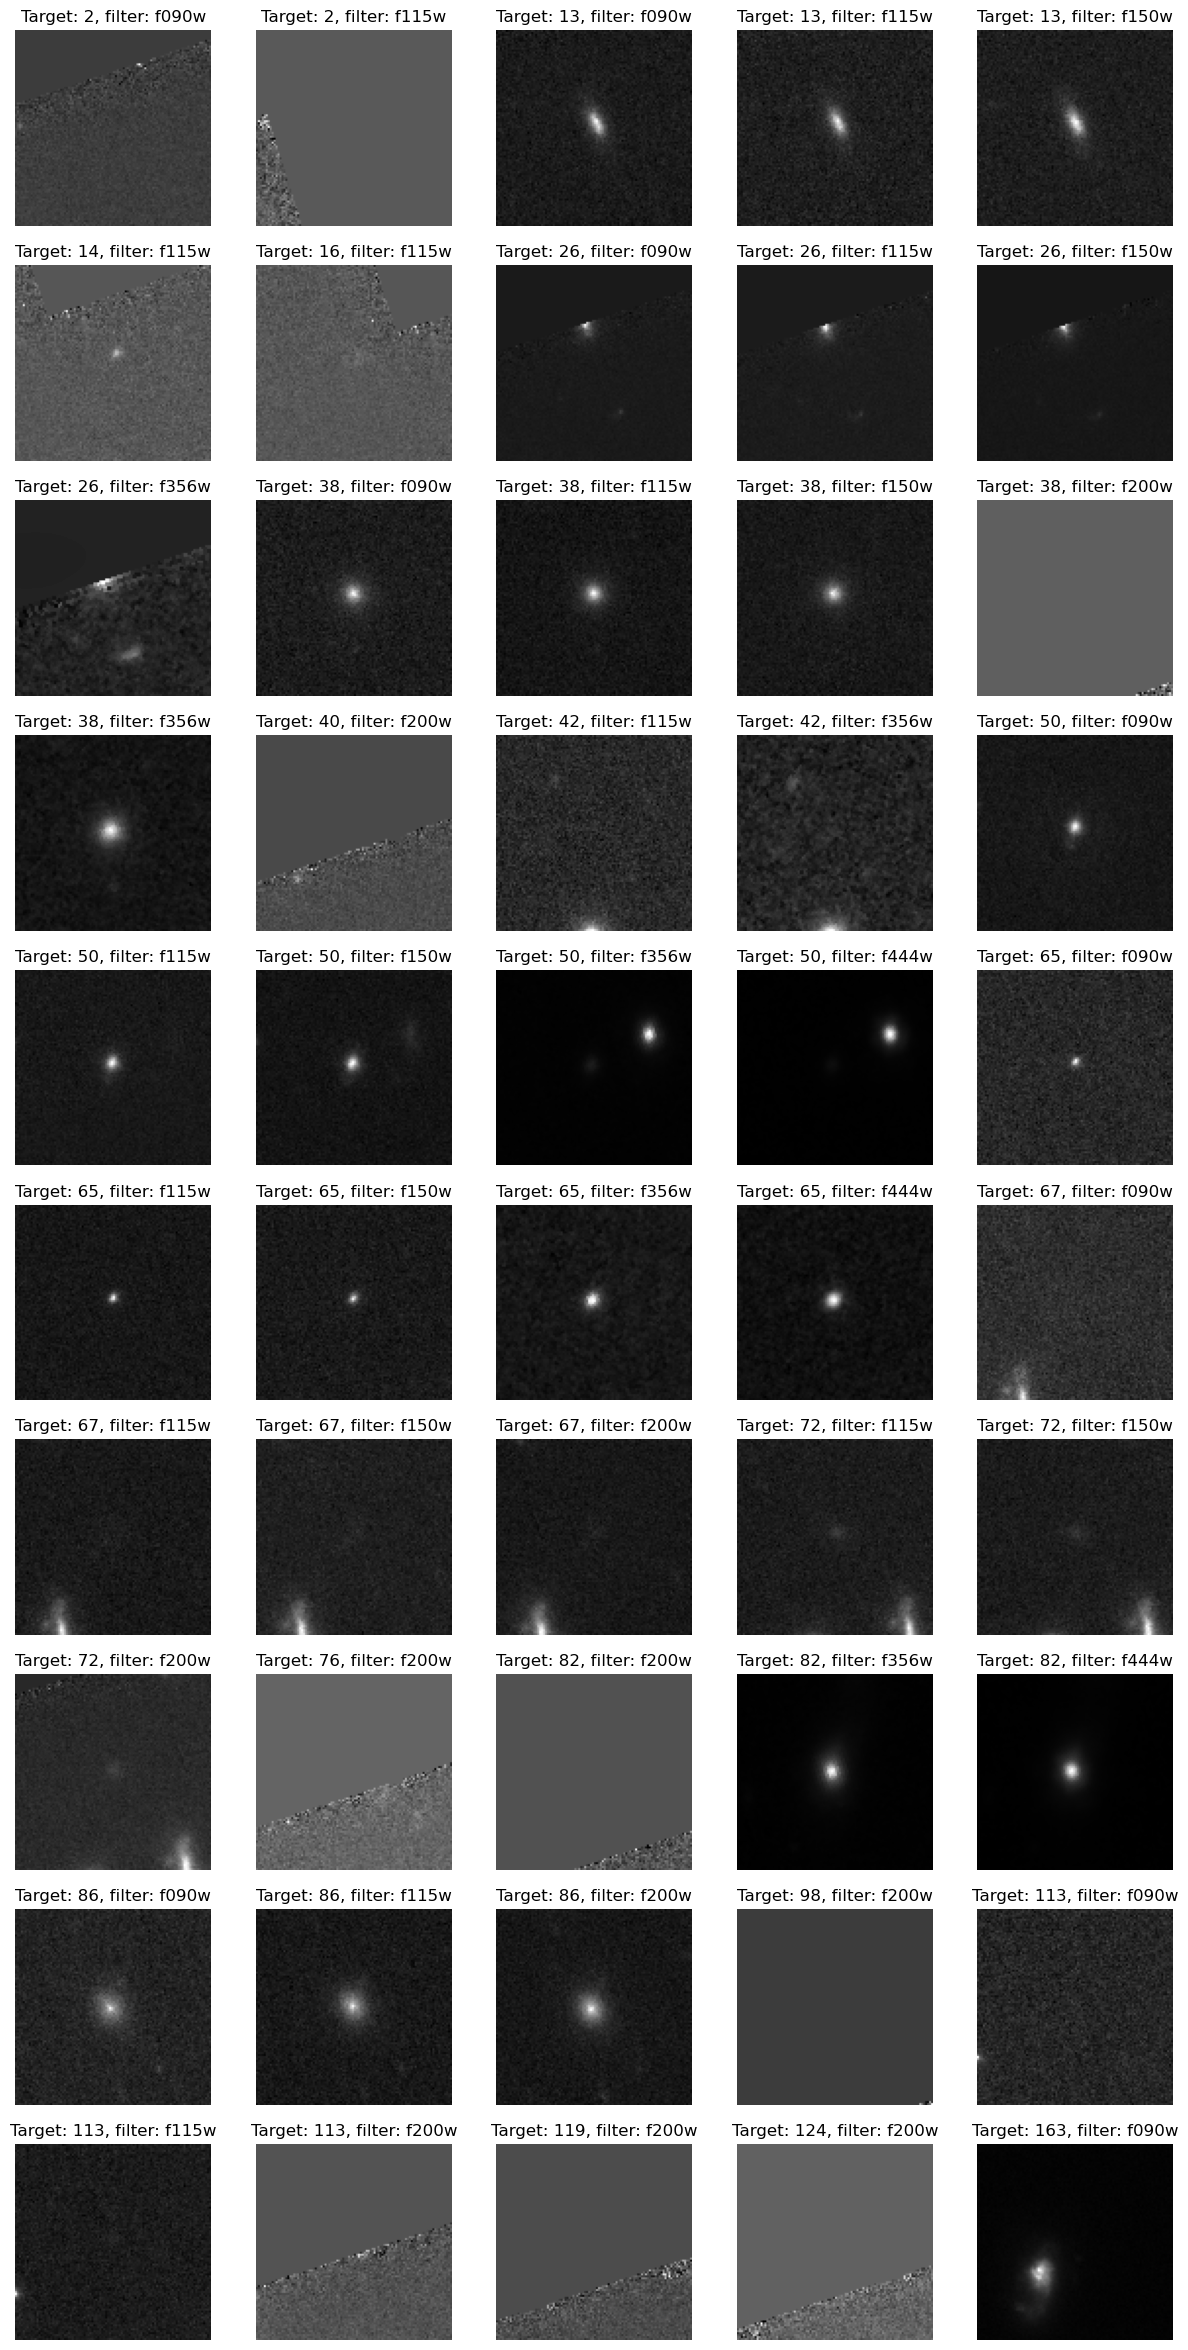

In [154]:
pixel_peaks = np.max(images, axis=(2,3))
pixel_stds = np.std(images, axis=(2,3))

psnr = pixel_peaks/pixel_stds

threshold = 15

low_noise_target, low_noise_filter = np.where(psnr > threshold)

low_noise_images = images[low_noise_target, low_noise_filter]

#plot a sample of the images

fig, axes = plt.subplots(10, 5, figsize=(15, 30))
axes = axes.flatten()

for i in range(10*5):
    axes[i].imshow(low_noise_images[i], cmap='gray')
    axes[i].set_title(f'Target: {target_names[low_noise_target[i]]}, filter: {filters[low_noise_filter[i]]}')
    axes[i].axis('off')

This method of filtering noisey images works quite well, however may not be a standard way to characterise noise and may not be as intuitive to readers if not properly explained. 
From the sample above the dataset needs to be further filtered. There are a number of images that have artifacts, likely the target it at the edge of the field of view and the image is cut off. These images are not useful for the lens model and should be removed. The next section aims to build a method to identify and remove these images.

### Filtering images with artifacts

Value: 0.0, Index: 0, Count: 5626


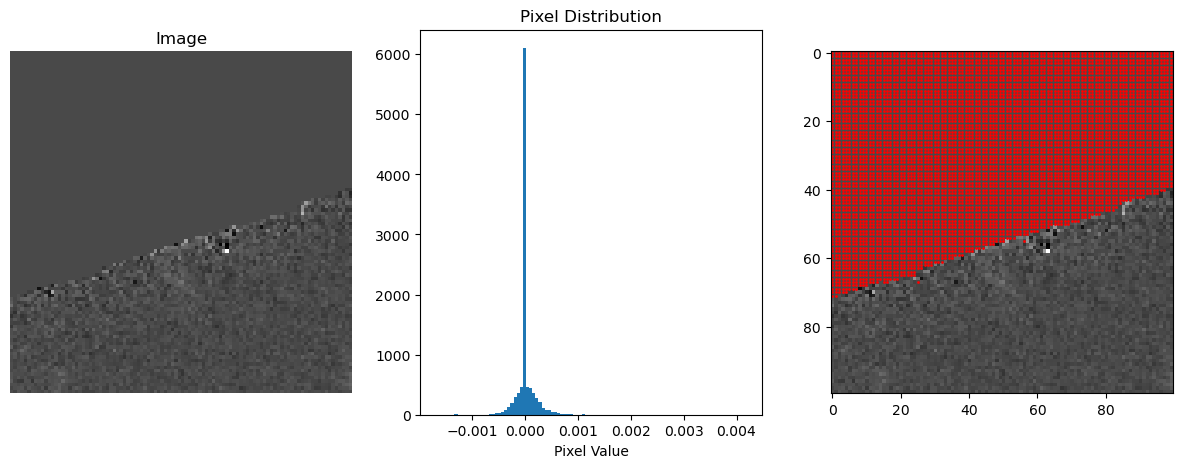

In [155]:
image_test_artifact = fits.open(f'{directory}{217}_f200w.fits')[0].data
image_test_artifact_dist = image_test_artifact.flatten()

unique_vals, indices = np.unique(image_test_artifact, return_index=True)

for val, idx in zip(unique_vals, indices):
    if len(np.where(image_test_artifact == val)[0]) > 1:
        print(f'Value: {val}, Index: {idx}, Count: {len(np.where(image_test_artifact == val)[0])}')

idx = np.where(image_test_artifact == 0)

fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].imshow(image_test_artifact, cmap='gray')
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].hist(image_test_artifact_dist, bins=100)
ax[1].set_title('Pixel Distribution')
ax[1].set_xlabel('Pixel Value')

ax[2].imshow(image_test_artifact, cmap='gray')
ax[2].scatter(idx[1], idx[0], color='r', s=1)




In [125]:
def filter_artifacts(images):
    artifact_indices = []
    for i in range(images.shape[0]):
        hist, bins = np.histogram(images[i].flatten(), bins=100)
        # find the first two maxima in the hist
        maxima = np.sort(hist)[-2:]
        if np.diff(maxima)[0] > 100:
            artifact_indices.append(i)

    # Return images without artifacts
    return np.delete(images, artifact_indices, axis=0), artifact_indices

There are 1113 in the final selection
There are 500 unique targets in the final selection


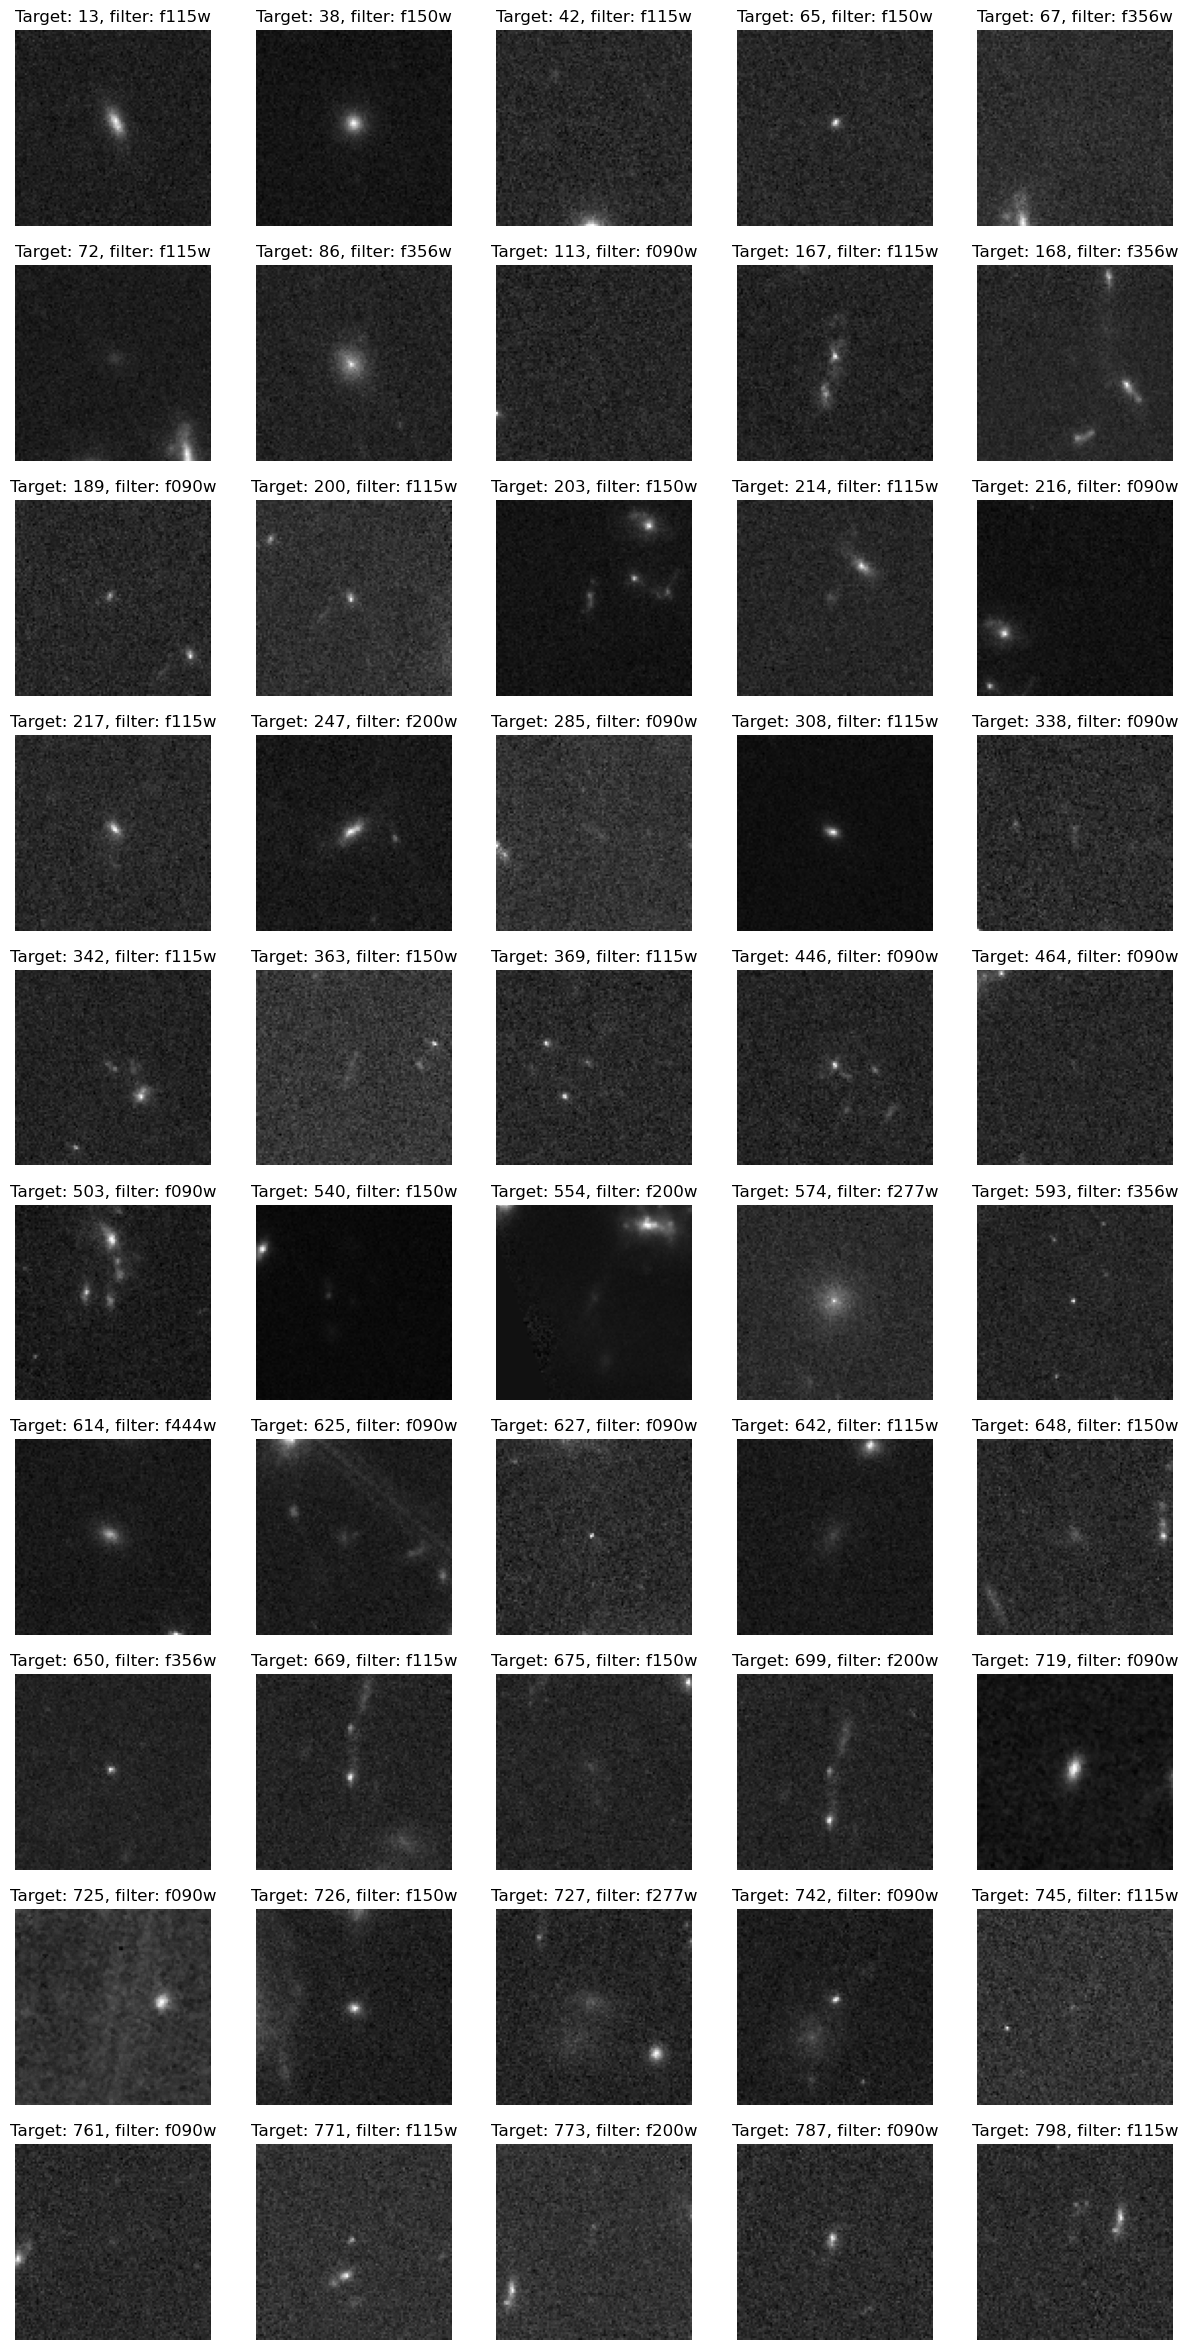

In [126]:
images_filtered, artifact_indices = filter_artifacts(np.array(low_noise_images))
low_noise_target_filtered = np.delete(low_noise_target, artifact_indices)
low_noise_filters_filtered = np.delete(low_noise_filter, artifact_indices)

filtered_target_names = target_names[low_noise_target_filtered]

print(f"There are {len(images_filtered)} in the final selection")
print(f'There are {len(np.unique(filtered_target_names))} unique targets in the final selection')

# Plot a sample of the images
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
axes = axes.flatten()

unique_list = []
unique_idx = []

for i in range(len(images_filtered)):  
    if filtered_target_names[i] not in unique_list:
        unique_list.append(filtered_target_names[i])
        unique_idx.append(i)


for i in range(10*5):  

    axes[i].imshow(images_filtered[unique_idx[i]], cmap='gray')
    axes[i].set_title(f'Target: {filtered_target_names[unique_idx[i]]}, filter: {filters[low_noise_filters_filtered[i]]}')
    axes[i].axis('off')
        



There are 1113 objects in the filtered catalog


<AxesSubplot:ylabel='Density'>

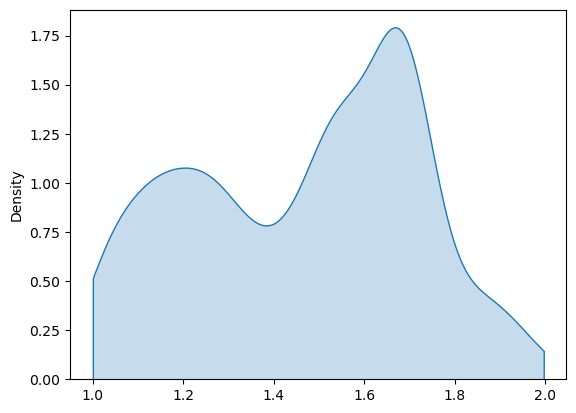

In [156]:

catalog_filtered = catalog.loc[filtered_target_names]
filtered_photoz = catalog_filtered['photoz'].values

print(f'There are {len(filtered_photoz)} objects in the filtered catalog')

# Compare distribution to the full catalog
sns.kdeplot(filtered_photoz, label='Filtered Catalog', cut=0, fill=True)


### Lens the sources

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.ImSim.image_model as im
import lenstronomy.Util.param_util as param_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
import lenstronomy.Util.util as util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Util import data_util
import os
from lenstronomy.SimulationAPI.sim_api import SimAPI
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

def Scale(filter):
    if unique_target_filters_filtered[i] in ['f277w','f356w','f444w']:
        scale = 0.063
    else:
        scale = 0.031
    return scale

def flux_to_mag(flux):
    return -2.5*np.log10(flux)+25

class lens_sim(object):

    def __init__(self, kwargs_light_list = None, source_model_list = None, lens_model_list = None, kwargs_lens_list = None, lens_redshift_list = None, source_redshift_list = None, numPix = 100, deltaPix = 0.03, psf_type = 'GAUSSIAN', psf_fwhm = 0.08, mag_zero_point = 30, exposure_time = 1, supersampling_factor = 10):
        # clump 1
        self.kwargs_light_list = kwargs_light_list
        self.source_model_list = source_model_list

        # lens
        self.lens_model_list = lens_model_list
        self.kwargs_lens_list = kwargs_lens_list

        # Configuration
        self.lens_redshift_list = lens_redshift_list
        self.source_redshift_list = source_redshift_list

        # image
        self.numPix = numPix
        self.deltaPix = deltaPix
        self.psf_type = psf_type
        self.psf_fwhm = psf_fwhm
        self.mag_zero_point = mag_zero_point
        self.exposure_time = exposure_time
        self.supersampling_factor = supersampling_factor


    def simulate(self):

        # Construct the lenstronomy image


        ## LensModel

        lensModel = LensModel(self.lens_model_list)

        ## SimAPI
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3)

        kwargs_single_band = {'read_noise': 0, 'pixel_scale': self.deltaPix, 'ccd_gain': 0, 'exposure_time': self.exposure_time, 'sky_brightness': 0, 'seeing': self.psf_fwhm, 'magnitude_zero_point': self.mag_zero_point, 'num_exposures': 1, 'background_noise': 0, 'psf_type': self.psf_type}
        kwargs_model = {'lens_model_list': self.lens_model_list, 'lens_redshift_list': self.lens_redshift_list, 'lens_light_model_list': ['SERSIC_ELLIPSE'], 'source_light_model_list': self.source_model_list, 'source_redshift_list': self.source_redshift_list, 'point_source_model_list': [], 'cosmo': cosmo, 'z_source': self.source_redshift_list[0]}

        
        sim = SimAPI(numpix=self.numPix,
                    kwargs_model=kwargs_model,
                    kwargs_single_band=kwargs_single_band)
        
        kwargs_light_lens = [{'magnitude': 24, 'R_sersic': 1, 'n_sersic': 2.5, 'e1': 0.2, 'e2': 0.1, 'center_x': 0, 'center_y': 0}]

        kwargs_light_lens, kwargs_light, _ = sim.magnitude2amplitude(kwargs_lens_light_mag=kwargs_light_lens, kwargs_source_mag=self.kwargs_light_list)

        light_model = LightModel(light_model_list=self.source_model_list)

        lens_light_model_list = ['SERSIC_ELLIPSE']
        lightModel_lens = LightModel(light_model_list=lens_light_model_list)

        ## DataClass

        # setup the keyword arguments to create the Data() class #

        _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=self.numPix, deltapix=self.deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

        kwargs_data = {'exposure_time': self.exposure_time,  # exposure time (or a map per pixel)
                    'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                    'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                    'image_data': np.zeros((self.numPix, self.numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
                }

        data_class = ImageData(**kwargs_data)

        ##PSF
        kwargs_psf = {'psf_type' : self.psf_type, 'fwhm' : self.psf_fwhm, 'pixel_size' : self.deltaPix}
        psf = PSF(**kwargs_psf)

        ### ImSim ###
                
        kwargs_numerics = {'supersampling_factor': self.supersampling_factor}
        imageModel = ImageModel(data_class=data_class, 
                                psf_class=psf, 
                                lens_model_class=lensModel, 
                                source_model_class=light_model, 
                                kwargs_numerics=kwargs_numerics,
                                lens_light_model_class=lightModel_lens,
                                )
        image = imageModel.image(kwargs_lens=self.kwargs_lens_list, 
                                kwargs_source=kwargs_light,
                                kwargs_lens_light=kwargs_light_lens
                            )

        unconvolved_image = imageModel.image(kwargs_lens=self.kwargs_lens_list, 
                                kwargs_source=kwargs_light,
                                kwargs_lens_light=kwargs_light_lens,
                                unconvolved=True
                            )

        
        return image, unconvolved_image

In [161]:
unique_target_image_filtered = images_filtered[unique_idx]
unique_target_filters_filtered = filters[low_noise_filters_filtered[unique_idx]]

unconvolved_images = []
convolved_images = []

for i in range(len(unique_target_image_filtered)):
    
    scale = Scale(unique_target_filters_filtered[i])
    mag = flux_to_mag(np.sum(unique_target_image_filtered[i]))

    #kwargs
    kwargs_light_list = [{'image': unique_target_image_filtered[i], 'magnitude': mag, 'center_x': 0., 'center_y': 0, 'phi_G': 0, 'scale': scale}
                        ]

    kwargs_lens_list = [{'theta_E': 1, 'e1': 0.2, 'e2': 0, 'center_x': 0, 'center_y': 0}
                        ]

    light_model_list = ['INTERPOL']
    lens_model_list = ['SIE'
                    ]

    source_redshift_list = [1]
    lens_redshift_list = [0.2]

    # create the image
    image = lens_sim(kwargs_light_list=kwargs_light_list, 
                    kwargs_lens_list=kwargs_lens_list, 
                    source_model_list=light_model_list, 
                    lens_model_list=lens_model_list,
                    source_redshift_list=source_redshift_list,
                    lens_redshift_list=lens_redshift_list,)
    Image, Unconvolved_Image = image.simulate()

    unconvolved_images.append(Unconvolved_Image)
    convolved_images.append(Image)


f115w
f115w
f115w
f090w
f090w
f115w
f090w
f090w
f090w
f115w
f090w
f090w
f090w
f150w
f090w
f090w
f115w
f090w
f090w
f150w
f090w
f090w
f090w
f150w
f090w
f150w
f200w
f200w
f090w
f115w
f090w
f200w
f115w
f200w
f090w
f090w
f200w
f115w
f200w
f277w
f356w
f090w
f115w
f090w
f115w


/tmp/ipykernel_3235870/3638509946.py:26: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux)+25


f150w
f150w
f150w
f090w
f150w
f090w
f090w
f200w


KeyboardInterrupt: 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

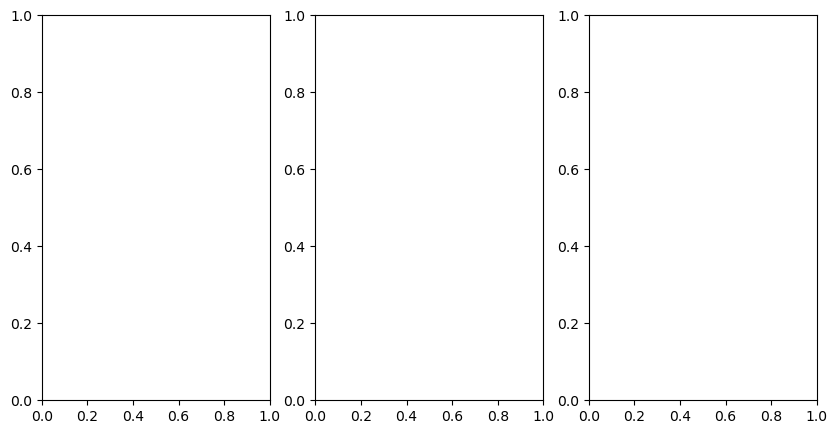

In [140]:

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

for i in range(1):

    shot_noise = np.random.normal(1, 0.1, size=unique_target_image_filtered[i].shape)
    background_noise = np.random.normal(0, np.std(unique_target_image_filtered[i])/3, size=unique_target_image_filtered[i].shape)

    ax[i,0].imshow(unique_target_image_filtered[i], cmap='gray')
    ax[i,0].set_title('Source')
    ax[i,0].axis('off')

    ax[i,1].imshow(unconvolved_images[i], cmap='gray')
    ax[i,1].set_title('Unconvolved Image')
    ax[i,1].axis('off')

    ax[i,2].imshow(convolved_images[i]*shot_noise+background_noise, cmap='gray')
    ax[i,2].set_title('Lens + PSF + Noise')
    ax[i,2].axis('off')



### Summary